# Overview

## Library Import

In [192]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error



import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## Data Import

In [2]:
spy_data = pd.read_csv("../data/spy_daily01.csv")
spy_data.head()

,to_datetime,open,high,low,close,volume
0,2018-10-15 01:00:00.000000,275.55,277.04,274.30,274.40,102263717
1,2018-10-16 01:00:00.000000,276.60,280.82,276.07,280.40,118255834
2,2018-10-17 01:00:00.000000,280.44,281.15,277.56,280.45,110625987
3,2018-10-18 01:00:00.000000,279.40,280.07,274.97,276.40,134557530
4,2018-10-19 01:00:00.000000,277.13,279.30,275.47,276.25,139901630


In [12]:
datalength = spy_data.shape[0] #543
prediction_length = 7
train_data_idx = 543 - prediction_length

In [14]:
model_data = spy_data["close"]
train_data = model_data[:train_data_idx]
test_data = model_data[train_data_idx:]

## Statsmodel ARIMA 

In [175]:
def ARIMA_gridsearch(p_max:int, d_max:int, q_max:int, data, prediction_length):
    return_list = [] #initialize return list
    train_data_idx = len(data) - prediction_length
    train = data[:train_data_idx] #slice train and test data
    test = data[train_data_idx:]
    p_range = range(1, p_max) #set ARIMA ranges
    d_range = range(0, d_max)
    q_range = range(1, q_max)
    for p in p_range: #loop through ARIMA ranges
        for d in d_range:
            for q in q_range:
                model = ARIMA(train, order=(p,d,q)) #fit and predict
                arima_model = model.fit()
                model_prediction = arima_model.forecast(steps=prediction_length)
                warning = arima_model.mle_retvals["warnflag"]
                convergence = arima_model.mle_retvals["converged"]
                rmse_result = np.sqrt(mean_squared_error(test, model_prediction)) #get rmse
                return_list.append([p,d,q,convergence, warning, rmse_result])
    return sorted(return_list, key=lambda x: (x[-1], x[-2], (x[-3]*-1)))
                

In [176]:
ARIMA_gridsearch(3, 2, 3, model_data, 30)

[[1, 1, 1, True, 0, 21.122590096525915],
 [2, 1, 1, True, 0, 22.031848770947207],
 [2, 1, 2, True, 0, 22.063184264820173],
 [1, 1, 2, True, 0, 22.192815202928404],
 [1, 0, 1, True, 0, 26.26582426681134],
 [2, 0, 1, True, 0, 26.733401877198606],
 [2, 0, 2, True, 0, 30.199449566156417],
 [1, 0, 2, True, 0, 30.677539325442016]]

In [121]:
mod_arma = ARIMA(train_data, order=(2, 2, 2))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Yung\Anaconda3\envs\fitsnbits\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  536
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1544.810
Date:                Wed, 16 Dec 2020   AIC                           3099.620
Time:                        18:08:28   BIC                           3121.022
Sample:                             0   HQIC                          3107.994
                                - 536                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1728      0.028    -41.594      0.000      -1.228      -1.118
ar.L2         -0.2664      0.021    -12.541      0.000      -0.308      -0.225
ma.L1         -0.0278      0.137     -0.203      0.8

In [122]:
res_arma.mle_retvals 

{'fopt': 2.8821081832189432,
 'gopt': array([-1.12825305e-06, -8.62043770e-06,  1.51523238e-07, -5.70210545e-08,
        -2.49165133e-06]),
 'fcalls': 174,
 'warnflag': 0,
 'converged': True,
 'iterations': 24}

In [123]:
prediction = res_arma.forecast(steps=prediction_length)

In [124]:
rmse_result = np.sqrt(mean_squared_error(test_data, prediction))

In [125]:
rmse_result

5.174168885450795

In [126]:
prediction

536    362.322623
537    362.839275
538    362.559214
539    363.145844
540    362.928265
541    363.422980
542    363.296554
Name: predicted_mean, dtype: float64

In [127]:
test_data

536    366.02
537    366.79
538    366.69
539    369.85
540    369.09
541    370.17
542    366.85
Name: close, dtype: float64

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

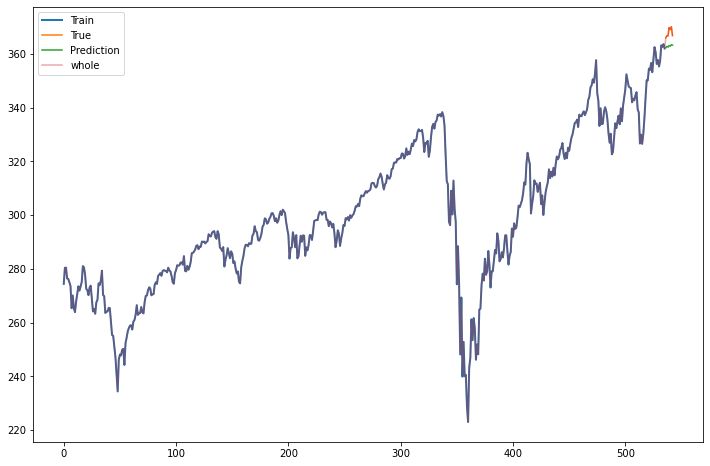

In [129]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train_data, label="Train", linewidth=2)
ax.plot(test_data, label="True")
ax.plot(prediction, label="Prediction")
ax.plot(model_data, label="whole", alpha=0.4)
plt.legend()

## Rolling Prediction 

predict next 5 days using 25 days

In [223]:
rolling_pred = pd.Series(dtype="float64")
model_data = spy_data["close"]
given_length = 25
prediction_length = 5
index=0

while index < len(model_data): #while loop for rolling prediction
    index_stop = index + prediction_length
    if len(model_data) - index_stop < given_length:
        index_stop = len(model_data)
    #print(index, index_stop)
    train_data = model_data[index:index_stop]
    mod_arma = ARIMA(train_data, order=(2, 0, 1))
    res_arma = mod_arma.fit()
    prediction = res_arma.forecast(steps=prediction_length)
    rolling_pred = pd.concat([rolling_pred, prediction])
    index += prediction_length

5.43358423255595


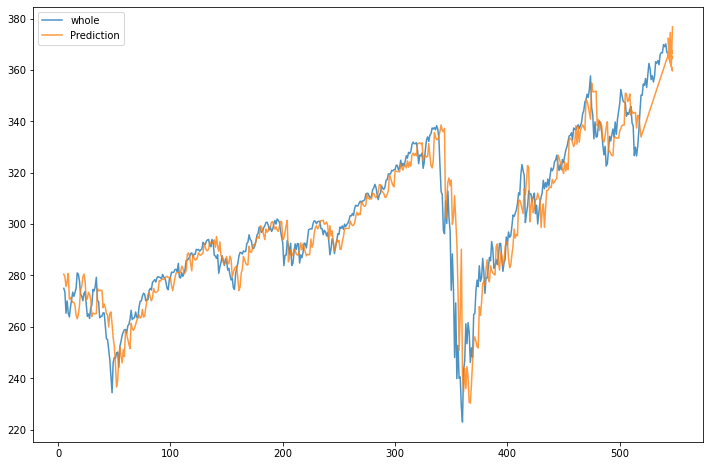

In [224]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(model_data[rolling_pred.index[0]:], label="whole", alpha=0.8)
ax.plot(rolling_pred, label="Prediction", alpha=0.8)

plt.legend()

print(np.sqrt(mean_squared_error(model_data, rolling_pred[:(model_data.index[-1]+1)])))

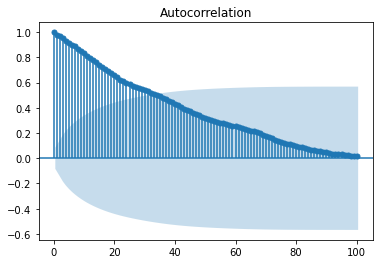

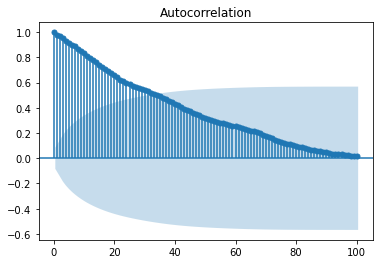

In [201]:
plot_acf(model_data.values, lags=100)

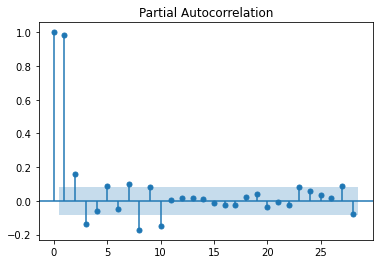

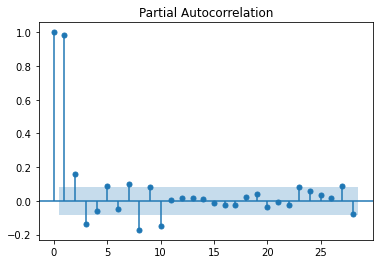

In [197]:
plot_pacf(model_data.values)

In [ ]:
(3, 1, 3) 9.255257316770185
(2, 1, 2) 8.057444318001506
(1, 1, 1) 6.980702802347007
(1, 0, 1) 5.027656513721162
(2, 0, 0) 5.245
(2, 0, 1) 5.43